# Modeling for Capstone 2
This notebook deploys several models to assess the FARS dataset.

# Table of Contents 
1. [Research Questions](#id0)
2. [Import Packages](#id1)
3. [Load the Data](#id2)
4. [Test Train Split for Total](#id3)
5. [Model Evaluation](#id4)
6. [Linear Regression](#id5)
7. [Ordinary Least Squares](#id6)
8. [Decision Tree Regressor](#id7)
9. [Lasso Regression](#id8)
10. [Recursive Feature Elimination](#id9)
11. [Recursive Feature Elimination (RFE)](#id10)
12. [Dataset Trimming](#id11)
13. [Linear Regression with Trimmed Features](#id12)
14. [Lasso with Cross-fold Validation with Trimmed Features](#id13)
14. [Decision Tree Regressor with Trimmed Features](#id14)
15. [Overall Trimmed](#id15)


<a id="id0"></a>

## Research Questions

In considering the transformation of rural areas into nonrural areas in the US, what factors most strongly predict fatal crashes in each context for the year under consideration and thereby what is predictable as this transformation continues? Will there be more fatal crashes if rural areas are transformed to urban areas? Do rural and urban areas have the same factors that correlate with fatalities.


<a id="id1"></a>

## Import Packages

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import ppscore as pps
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.lines as lines
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

<a id="id2"></a>

## Load the Data

In [23]:
#Import total; will test and train within total and keep rural/urban as a factor

total = pd.read_csv('../data/processed/total.csv')

In [24]:
total.head(3)

,STATENAME,VE_TOTAL,PEDS,PERSONS,DAYNAME,MONTHNAME,HOUR,DAY_WEEKNAME,RUR_URBNAME,HARM_EVNAME,...,DRUNK_DR,REGION,WEEK_END,DAY_NIGHT,DayNight_Avg,WEEK_END_Avg,State_Avg,Day_Avg,Region_Avg,F_RATIO
0,Michigan,1,0,1,11,November,14,Monday,Urban,Guardrail End,...,0,Midwest,Weekday,Night_Time,1.085086,1.078599,1.091916,1.073699,1.093226,100.0
1,Wisconsin,1,0,1,5,January,9,Saturday,Rural,Railway Vehicle,...,0,Midwest,Weekend,Night_Time,1.085086,1.100224,1.079681,1.099804,1.093226,100.0
2,Wisconsin,1,0,1,7,January,9,Monday,Urban,Traffic Signal Support,...,0,Midwest,Weekday,Night_Time,1.085086,1.078599,1.079681,1.073699,1.093226,100.0


In [25]:
total.columns

Index(['STATENAME', 'VE_TOTAL', 'PEDS', 'PERSONS', 'DAYNAME', 'MONTHNAME',
       'HOUR', 'DAY_WEEKNAME', 'RUR_URBNAME', 'HARM_EVNAME', 'LGT_CONDNAME',
       'WEATHER1NAME', 'WEATHERNAME', 'FATALS', 'DRUNK_DR', 'REGION',
       'WEEK_END', 'DAY_NIGHT', 'DayNight_Avg', 'WEEK_END_Avg', 'State_Avg',
       'Day_Avg', 'Region_Avg', 'F_RATIO'],
      dtype='object')

The columns 'DayNight_Avg', 'WEEK_END_Avg', 'State_Avg','Day_Avg', and 'Region_Avg'are themselves measures of fatalities for certain criteria. They are not factors. Fatalities is an alternative dependent variable, but F_Ratio is a more helpful measure. Fatalities and the other measures will be dropped.

In [26]:
total = total[['STATENAME', 'VE_TOTAL', 'PEDS', 'PERSONS', 'DAYNAME', 'MONTHNAME',
       'HOUR', 'DAY_WEEKNAME', 'RUR_URBNAME', 'HARM_EVNAME', 'LGT_CONDNAME',
       'WEATHER1NAME', 'WEATHERNAME', 'DRUNK_DR', 'REGION',
       'WEEK_END', 'DAY_NIGHT','F_RATIO']]

In [27]:
total.columns

Index(['STATENAME', 'VE_TOTAL', 'PEDS', 'PERSONS', 'DAYNAME', 'MONTHNAME',
       'HOUR', 'DAY_WEEKNAME', 'RUR_URBNAME', 'HARM_EVNAME', 'LGT_CONDNAME',
       'WEATHER1NAME', 'WEATHERNAME', 'DRUNK_DR', 'REGION', 'WEEK_END',
       'DAY_NIGHT', 'F_RATIO'],
      dtype='object')

In [28]:
print('total shape is', total.shape)

total shape is (33238, 18)


In [29]:
### In the Modeling below, the lowest F_Ratio is throwing off the graphing and predicting. 
###Those below I will drop to try and clean up the graphs below. There are 4 rows with an F_Ratio < 5
total.sort_values(by=['F_RATIO']).head()

,STATENAME,VE_TOTAL,PEDS,PERSONS,DAYNAME,MONTHNAME,HOUR,DAY_WEEKNAME,RUR_URBNAME,HARM_EVNAME,LGT_CONDNAME,WEATHER1NAME,WEATHERNAME,DRUNK_DR,REGION,WEEK_END,DAY_NIGHT,F_RATIO
33237,Kentucky,12,0,30,28,June,16,Friday,Rural,Motor Vehicle In-Transport,Daylight,Clear,Clear,0,South,Weekday,Night_Time,3.333
33236,Virginia,1,0,57,19,March,5,Tuesday,Rural,Ditch,Dark - Not Lighted,"Fog, Smog, Smoke","Fog, Smog, Smoke",0,South,Weekday,Day_Time,3.509
33235,New Jersey,2,0,24,24,January,19,Thursday,Urban,Motor Vehicle In-Transport,Dark - Lighted,Clear,Clear,0,Northeast,Weekday,Night_Time,4.167
33234,Nevada,8,0,21,6,July,20,Saturday,Urban,Motor Vehicle In-Transport,Dark - Lighted,Clear,Clear,0,West,Weekend,Night_Time,4.762
33233,North Carolina,3,0,18,14,May,14,Tuesday,Rural,Motor Vehicle In-Transport,Daylight,Clear,Clear,0,South,Weekday,Night_Time,5.556


In [30]:
total = total[total.F_RATIO > 5]

In [31]:
total.sort_values(by=['F_RATIO']).head()

,STATENAME,VE_TOTAL,PEDS,PERSONS,DAYNAME,MONTHNAME,HOUR,DAY_WEEKNAME,RUR_URBNAME,HARM_EVNAME,LGT_CONDNAME,WEATHER1NAME,WEATHERNAME,DRUNK_DR,REGION,WEEK_END,DAY_NIGHT,F_RATIO
33233,North Carolina,3,0,18,14,May,14,Tuesday,Rural,Motor Vehicle In-Transport,Daylight,Clear,Clear,0,South,Weekday,Night_Time,5.556
33228,North Carolina,7,0,17,21,July,14,Sunday,Rural,Motor Vehicle In-Transport,Daylight,Clear,Clear,0,South,Weekend,Night_Time,5.882
33229,Ohio,16,0,17,12,November,8,Tuesday,Urban,Motor Vehicle In-Transport,Daylight,Snow,Snow,0,Midwest,Weekday,Night_Time,5.882
33232,Arizona,7,0,17,13,April,16,Saturday,Urban,Motor Vehicle In-Transport,Daylight,Clear,Clear,0,West,Weekend,Night_Time,5.882
33231,Florida,2,0,17,22,January,18,Tuesday,Urban,Motor Vehicle In-Transport,Dark - Lighted,Clear,Clear,0,South,Weekday,Night_Time,5.882


<a id="id3"></a>

## Test Train Split for Total


In [32]:
### Sorting out the categorical variables
dfo = total.select_dtypes(include=['object']) # select object type columns
total_ready = pd.concat([total.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1) ### concatenating the dummy filled columns
total_ready.columns

Index(['VE_TOTAL', 'PEDS', 'PERSONS', 'DAYNAME', 'HOUR', 'DRUNK_DR', 'F_RATIO',
       'STATENAME_Alabama', 'STATENAME_Alaska', 'STATENAME_Arizona',
       ...
       'WEATHERNAME_Sleet or Hail', 'WEATHERNAME_Snow', 'REGION_Midwest',
       'REGION_Northeast', 'REGION_South', 'REGION_West', 'WEEK_END_Weekday',
       'WEEK_END_Weekend', 'DAY_NIGHT_Day_Time', 'DAY_NIGHT_Night_Time'],
      dtype='object', length=180)

In [33]:
### Test Train Split for total
X = total_ready.loc[:, total_ready.columns!='F_RATIO']
y = total_ready.F_RATIO

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [34]:
# For Total, build scaler based on training data and apply it to X_test data 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [35]:
# For Total, We now want to check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
print('Total accident training data', X_train_scaled.shape, ';', 'Total accident test data', X_test_scaled.shape, "\n", 'total fatality training data', y_train.shape,';', 'total fatality testing data', y_test.shape) 


Total accident training data (23263, 179) ; Total accident test data (9971, 179) 
 total fatality training data (23263,) ; total fatality testing data (9971,)



Data for total dataset is test/train split and then scaled to avoid data leakage.

<a id="id4"></a>

## Model Evaluation

<a id="id5"></a>

### Linear Regression

In [49]:
# Using linear regression for the entire Total set
rModel = linear_model.LinearRegression()

In [50]:
rModel.fit(X_train_scaled, y_train)

LinearRegression()

In [51]:
# Evaluate the model: And a halfway decent R-Squared score for a full go; Ok comparison for the test score. 
# Not overfit or underfit

print("Training R-sqaured for simple linear regression:", rModel.score(X_train_scaled, y_train))
print("Testing R-squared for simple linear regression:", rModel.score(X_test_scaled, y_test))

Training R-sqaured for simple linear regression: 0.7107888460023336
Testing R-squared for simple linear regression: 0.7157144287978345


In [52]:
# Use the model to make predictions about our test data
y_pred = rModel.predict(X_test_scaled)

In [53]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error with Linear Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred)), 2))
print('The Mean Absolute Error with Linear Regression:', round(mean_absolute_error(y_test,y_pred), 2))
print('Coefficient of determination with Linear Regression:', round(r2_score(y_test,y_pred), 2))

The Root Mean Squared Error with Linear Regression: 15.21
The Mean Absolute Error with Linear Regression: 10.99
Coefficient of determination with Linear Regression: 0.72


FileNotFoundError: [Errno 2] No such file or directory: '../figures/Actual vs Predicted for Linear Regression.png'

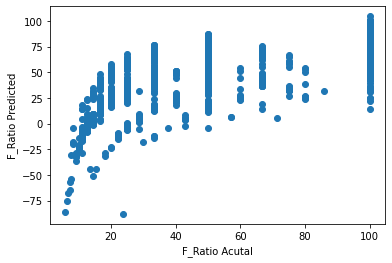

In [55]:
# Let's plot the predictions against the actual result. Use scatter()
# appears that there is an exponential curve to the relationship
_ = plt.scatter(y_test, y_pred)
_ = plt.ylabel('F_Ratio Predicted')
_ = plt.xlabel('F_Ratio Acutal')
plt.savefig('../figures/Actual vs Predicted for Linear Regression');

<a id="id6"></a>


## Oridinary Least Squares

In [ ]:
model_OLS = sm.OLS(y_train, X_train_scaled)

# Fit the model
model_OLS = model_OLS.fit()



In [ ]:
# Evaluating the model; much lower R-squared here
model_OLS.summary()

In [ ]:
# Use our new model to make predictions
y_pred = model_OLS.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error. Yikes on all three for OLS
print('The Root Mean Squared Error with OLS:', round(np.sqrt(mean_squared_error(y_test,y_pred)), 2))
print('The Mean Absolute Error with OLS:', round(mean_absolute_error(y_test,y_pred), 2))
print('Coefficient of determination with OLS:', round(r2_score(y_test,y_pred), 2))

In [ ]:
# Plot the predictions
# Build a scatterplot
plt.scatter(y_test, y_pred)
_ = plt.ylabel('F_Ratio Predicted')
_ = plt.xlabel('F_Ratio Acutal')
plt.savefig('../figures/Actual vs Predicted for Ordinary Least Squares')

<a id="id7"></a>

### Decision Tree Regressor

In [ ]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_train_scaled, y_train)
y_pred_tree1 = tree_reg1.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error. TREE WITH DEPTH 2
print('The Root Mean Squared Error Decision Tree Regression Depth 2:', round(np.sqrt(mean_squared_error(y_test,y_pred_tree1)), 2))
print('The Mean Absolute Error Decision Tree Regression Depth 2:', round(mean_absolute_error(y_test,y_pred_tree1), 2))
print('Coefficient of determination Decision Tree Regression Depth 2:', round(r2_score(y_test,y_pred_tree1), 2))

In [ ]:
# Evaluate the model: And a halfway decent R-Squared score for a full go; Ok comparison for the test score. 
# Not overfit or underfit
print("Training R-sqaured for Decision Tree Regression Depth 2:", tree_reg1.score(X_train_scaled, y_train))
print("Testing R-squared for Decision Tree Regression Depth 2:", tree_reg1.score(X_test_scaled, y_test))

In [ ]:
tree_reg2 = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_reg2.fit(X_train_scaled, y_train)
y_pred_tree2 = tree_reg2.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_tree2)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_tree2), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_tree2), 2))

In [ ]:
tree_reg2 = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_reg2.fit(X_train_scaled, y_train)
y_pred_tree3 = tree_reg2.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_tree3)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_tree3), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_tree3), 2))

In [ ]:
# Evaluate the model: And a halfway decent R-Squared score for a full go; Ok comparison for the test score. 
# Not overfit or underfit

print("Training R-sqaured for Decision Tree Regression Depth 5:", tree_reg2.score(X_train_scaled, y_train))
print("Testing R-squared for Decision Tree Regression Depth 5:", tree_reg2.score(X_test_scaled, y_test))

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error. TREE WITH DEPTH 5
print('The Root Mean Squared Error Decision Tree Regression Depth 5:', round(np.sqrt(mean_squared_error(y_test,y_pred_tree2)), 2))
print('The Mean Absolute Error Decision Tree Regression Depth 5:', round(mean_absolute_error(y_test,y_pred_tree2), 2))
print('Coefficient of determination Decision Tree Regression Depth 5:', round(r2_score(y_test,y_pred_tree2), 2))

In [ ]:
features = X_train
importances = list(tree_reg2.feature_importances_)
imp=sorted(importances, reverse=False)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tab)

The results with the Decision Tree Regressor indicate that Night time is influential (and more so than day time) and that Weekend is slightly influential (and more so than Week day).

<a id="id8"></a>

### Lasso Regression

In [ ]:
### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso.score
### Working with Lasso regression to attend to possible overfitting
Lasso_model = Lasso(alpha=1.0) ##full penalty for the alpha in this go around
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
Lasso_scores = cross_val_score(Lasso_model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
Lasso_scores = absolute(Lasso_scores)
print(Lasso_scores)
### Looks like overfitting is not a big issue

In [ ]:
Lasso_model.fit(X_train_scaled, y_train)

In [ ]:
# Use the model to make predictions about our test data
y_pred_Lasso = Lasso_model.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error. Yikes on the R2
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_Lasso)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_Lasso), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_Lasso), 2))

<a id="id9"></a>

## Recursive feature elimination (RFE)

In [ ]:
### RFE with Lasso; the Linear Regresssion was horrible; Lasso much better: What up?
### In this section, let's see if we can pair down the number of features to make it reasonable/interpretable as a model
# evaluate RFE for regression
# fit RFE
rfe = RFE(estimator=Lasso(alpha=1.0))
rfe.fit(X_train_scaled, y_train)
y_pred_rfe = rfe.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error; RFE is now doing horribly
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_rfe)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_rfe), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_rfe), 2))


In [ ]:
###Showing the rank for the columns; 
###clearly, there are differences in their ranking that can be used to pair the model
for i in range(X_train_scaled.shape[1]):
	print('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

In [ ]:
### RFE with Lasso CV
# evaluate RFE for regression
# fit RFE
rfe = RFE(estimator=Lasso(alpha=1.0), n_features_to_select=10)
model = Lasso(alpha=1.0)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
rfe_scores = absolute(scores)
print(rfe_scores)
### Overfitting not an issue

In [ ]:
R_scores = cross_val_score(pipeline, X_train_scaled, y_train, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('R2: %.3f (%.3f)' % (mean(R_scores), std(R_scores)))

In [ ]:
RMSE_scores = cross_val_score(pipeline, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
RMSE_scores = abs(RMSE_scores)
# report performance
print('R2: %.3f (%.3f)' % (mean(RMSE_scores), std(RMSE_scores)))

In [ ]:
###Showing the rank for the columns; clearly, there are differences in their ranking that can be used to pair the model
# fit RFE
rfe.fit(X_train_scaled, y_train)
# summarize all features
for i in range(X_train_scaled.shape[1]):
    if rfe.ranking_[i] < 5:
        f = open("Selected Columns.txt", 'a')
        f.write('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
        f.close
        print('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
    

In [ ]:
### Just checking with Linear Model with RFECV to see if it compares on autoselect of best features
from sklearn.feature_selection import RFECV

# Init, fit
rfecv = RFECV(
    estimator=Lasso(alpha=1.0),
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring="r2",
    cv=5)

_ = rfecv.fit(X_train_scaled, y_train)

In [ ]:
###With Cross-Validation LinearRegression, the RFE chose the following columns; Not Reported is new; 
###
X_train.columns[rfecv.support_]



<a id="id10"></a>

### Results from Full Feature Models
The results from the RFE with RepeatedKFold validation make the most sense as contributing conditions to a higher F_RATIO. Here are the factors ranked at 5 or lower (with 1 as most important).
___________________________________________________________________________
 PEDS, Selected True, Rank: 1.000  
 PERSONS, Selected True, Rank: 1.000  
 DRUNK_DR, Selected True, Rank: 1.000  
 RUR_URBNAME_Rural, Selected True, Rank: 1.000  
 HARM_EVNAME_Motor Vehicle In-Transport, Selected True, Rank: 1.000  
 HARM_EVNAME_Non-Motorist on Personal Conveyance, Selected True, Rank: 1.000  
 HARM_EVNAME_Pedalcyclist, Selected True, Rank: 1.000  
 HARM_EVNAME_Pedestrian, Selected True, Rank: 1.000  
 HARM_EVNAME_Traffic Signal Support, Selected True, Rank: 1.000  
 HARM_EVNAME_Tree (Standing Only), Selected True, Rank: 1.000  
 HARM_EVNAME_Other Object (not fixed), Selected False, Rank: 2.000  
 HARM_EVNAME_Other Non-Collision, Selected False, Rank: 3.000  
 HARM_EVNAME_Other Fixed Object, Selected False, Rank: 4.000

<a id="id11"></a>

## Dataset Trimming
With a trimmed dataset, given the indicators from the above analysis, the Decision Tree Regressor will be re-run.a

In [ ]:
### reloading Total (capitalized)
Total = pd.read_csv('../data/processed/total.csv')
Total.columns

In [ ]:
### Time to pair down some columns
#
Total = Total[['PEDS', 'PERSONS', 'DRUNK_DR', 'RUR_URBNAME', 'HARM_EVNAME','F_RATIO']]

#Total.columns
Total.head(3)

In [ ]:
print('Total shape is', Total.shape)

In [ ]:
### Sorting out the categorical variables
dfo = Total.select_dtypes(include=['object']) # select object type columns
Total_ready = pd.concat([Total.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1) ### concatenating the dummy filled columns

In [ ]:
### Because Harmful Events has been splayed and ONLY SOME of them were seen as important, 
### these themselves need to trimmed. Same goes with Rural_Urban which has four subtypes
Total_ready = Total_ready[['PEDS', 'PERSONS', 'DRUNK_DR', 'F_RATIO', 'RUR_URBNAME_Not Reported','RUR_URBNAME_Rural',
'HARM_EVNAME_Motor Vehicle In-Transport',
'HARM_EVNAME_Non-Motorist on Personal Conveyance', 
'HARM_EVNAME_Pedalcyclist',
'HARM_EVNAME_Pedestrian',  
'HARM_EVNAME_Traffic Signal Support',  
'HARM_EVNAME_Tree (Standing Only)',
'HARM_EVNAME_Other Object (not fixed)',  
'HARM_EVNAME_Other Non-Collision',   
'HARM_EVNAME_Other Fixed Object', ]]
Total_ready.columns

In [ ]:
### And to fix the really low four outliers of F_Ratio, let's filter
Total_ready = Total_ready[Total_ready.F_RATIO > 5]

In [ ]:
### Test Train Split for total
X = Total_ready.loc[:, Total_ready.columns!='F_RATIO']
y = Total_ready.F_RATIO

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [ ]:
# For Total, build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
# For Total, We now want to check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
print('Total accident training data', X_train_scaled.shape, 'Total accident test data', X_test_scaled.shape, "\n", 'total fatality training data', y_train.shape, 'total fatality testing data', y_test.shape)

<a id="id12"></a>

### Linear Regression with Trimmed Features

In [ ]:
# Using linear regression for the entire Total set
rModel = linear_model.LinearRegression()
rModel.fit(X_train_scaled, y_train)


In [ ]:
# Use the model to make predictions about our test data
y_pred_trim = rModel.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error. TREE WITH DEPTH 5
print('The Root Mean Squared Error with Linear Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred_trim)), 2))
print('The Mean Absolute Error with Linear Regression:', round(mean_absolute_error(y_test,y_pred_trim), 2))
print('Coefficient of Determination with Linear Regression:', round(r2_score(y_test,y_pred_trim), 2))

In [ ]:
### Good comparability between train and test sets
_ = rModel.fit(X_train_scaled, y_train)

print("Training R-sqaured:", rModel.score(X_train_scaled, y_train))
print("Testing R-squared:",rModel.score(X_test_scaled, y_test))

In [ ]:
# Let's plot the predictions against the actual result. Use scatter()
# appears that there is an exponential curve to the relationship
_ = plt.scatter(y_pred_trim, y_test)
_ = plt.xlabel('F_Ratio Predicted')
_ = plt.ylabel('F_Ratio Acutal')
_ = plt.title('Actual vs Predicted for Linear Regression')
plt.savefig('../figures/Actual vs Predicted for Linear Regression')

<a id="id13"></a>

### Lasso with Cross-fold Validation with Trimmed Features

In [ ]:
### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso.score
### Working with Lasso regression to attend to possible overfitting
Lasso_model2 = Lasso(alpha=1.0) ##full penalty for the alpha in this go around
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
Lasso_scores2 = cross_val_score(Lasso_model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
Lasso_scores2 = absolute(Lasso_scores2)
print(Lasso_scores2)
### Looks like overfitting is not a big issue

In [ ]:
Lasso_model2.fit(X_train_scaled, y_train)

In [ ]:
# Use the model to make predictions about our test data
y_pred_Lasso2 = Lasso_model2.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error. Yikes on the R2
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_Lasso2)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_Lasso2), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_Lasso2), 2))

<a id="id14"></a>

### Decision Tree Regressor with Trimmed Features

In [44]:
tree_reg2 = DecisionTreeRegressor(max_depth=5, random_state=42)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
tree_scores2 = cross_val_score(tree_reg2, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
tree_scores2 = absolute(tree_scores2)
print(tree_scores2)
### Looks like overfitting is not a big issue

[4.14211153 3.95502881 3.95519405 4.15933208 4.30515713 4.15666371
 4.1516189  3.97404375 3.89997156 3.87526606 3.92402935 3.9607852
 4.14227249 4.09266468 4.03572849 4.06059104 4.23164828 4.1031147
 3.9112639  3.96135979 4.09635803 4.07981596 4.11266798 4.27467634
 3.92127353 3.95194389 4.03175924 4.10892263 3.80245894 4.13307554]


In [46]:
tree_reg2.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [48]:
y_pred_tree2 = tree_reg2.predict(X_test_scaled)

In [ ]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_tree2)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_tree2), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_tree2), 2))

Calling Decision Tree Regression with max depth of 5 the winner based on RMSE and R2.  

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
# Let's plot the predictions against the actual result. Ugly plot though based on tree-ness
_ = plt.scatter(y_pred_tree2, y_test)
_ = plt.xlabel('F_Ratio Predicted')
_ = plt.ylabel('F_Ratio Acutal')
_ = plt.title('Actual vs Predicted for Decision Tree Regression')
plt.savefig('../figures/Actual vs Predicted for Decision Tree Regression')

<a id="id15"></a>

### Overall Trimmed
Through RFE with Lasso regression, we were able to trim the factors to those of greatest importance and get a model that has decent R2 without overfitting.